In [4]:
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Load the data
train_df = pd.read_csv('flint_training.csv', header=0)
test_df = pd.read_csv('flint_test.csv', header=0)

# We'll impute missing values using the median for numeric columns and the most
# common value for string columns.
from sklearn.base import TransformerMixin
class DataFrameImputer(TransformerMixin):
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.fill)

print(train_df.columns)

Index(['sample_id', 'Lead_(ppb)', 'parcel_id', 'Date_Submitted', 'google_add',
       'Latitude', 'Longitude', 'Owner_Type', 'Land_Value',
       'Land_Improvements_Value', 'Residential_Building_Value',
       'Residential_Building_Style', 'Commercial_Building_Value',
       'Building_Storeys', 'Parcel_Acres', 'Rental', 'Use_Type', 'Prop_Class',
       'Year_Built', 'USPS_Vacancy', 'Zoning', 'Future_Landuse', 'DRAFT_Zone',
       'Housing_Condition_2012', 'Housing_Condition_2014',
       'Commercial_Condition_2013', 'Hydrant_Type', 'Ward', 'PRECINCT',
       'CENTRACT', 'CENBLOCK', 'SL_Type', 'SL_Type2', 'SL_Lead', 'Homestead',
       'Homestead_Percent', 'HomeSEV', 'lead_binary', 'parcel_id_numeric',
       'parcel1', 'parcel2', 'Zipcode', 'Zoning_Cleaned', 'Land_Value_Norm',
       'Land_Improvements_Value_Norm', 'Residential_Building_Value_Norm',
       'Commercial_Building_Value_Norm', 'Year_Built_Cleaned', 'HomeSEV_Norm'],
      dtype='object')


In [18]:
feature_columns_to_use = [
       'Latitude', 'Longitude', 'Owner_Type',  
       'Residential_Building_Style', 
       'Building_Storeys', 'Parcel_Acres', 'Rental', 'Use_Type', 'Prop_Class',
        'USPS_Vacancy',  'Future_Landuse', 'DRAFT_Zone',
       'Housing_Condition_2012', 'Housing_Condition_2014',
       'Commercial_Condition_2013', 'Hydrant_Type', 'Ward', 'PRECINCT',
       'CENTRACT', 'CENBLOCK', 'SL_Type', 'SL_Type2', 'SL_Lead', 'Homestead',
       'Homestead_Percent',  'parcel_id_numeric',
       'parcel1', 'parcel2', 'Zipcode', 'Zoning_Cleaned', 'Land_Value_Norm',
       'Land_Improvements_Value_Norm', 'Residential_Building_Value_Norm',
       'Commercial_Building_Value_Norm', 'Year_Built_Cleaned', 'HomeSEV_Norm'
       ]
continuous_columns = [
             'Latitude', 'Longitude','parcel_id_numeric','Land_Value_Norm',
       'Land_Improvements_Value_Norm', 'Residential_Building_Value_Norm',
       'Commercial_Building_Value_Norm', 'Year_Built_Cleaned', 'HomeSEV_Norm',
       'parcel1', 'parcel2',
       ]
nonnumeric_columns = [  
         'Owner_Type',  
       'Residential_Building_Style', 
       'Building_Storeys', 'Parcel_Acres', 'Rental', 'Use_Type', 'Prop_Class',
        'USPS_Vacancy',  'Future_Landuse', 'DRAFT_Zone',
       'Housing_Condition_2012', 'Housing_Condition_2014',
       'Commercial_Condition_2013', 'Hydrant_Type', 'Ward', 'PRECINCT',
       'CENTRACT', 'CENBLOCK', 'SL_Type', 'SL_Type2', 'SL_Lead', 'Homestead',
       'Homestead_Percent',   'Zipcode', 'Zoning_Cleaned' ]

# nonnumeric_columns = ['Owner_Type']
# Join the features from train and test together before imputing missing values,
# in case their distribution is slightly different
big_X = train_df[feature_columns_to_use].append(test_df[feature_columns_to_use])
big_X_imputed = DataFrameImputer().fit_transform(big_X)
# big_X_imputed.to_csv("b.csv")

# XGBoost doesn't (yet) handle categorical features automatically, so we need to change
# them to columns of integer values.
# See http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing for more
# details and options
le = LabelEncoder()
onehot_encoder = OneHotEncoder()
# for feature in nonnumeric_columns:
#     big_X_imputed[feature]  = le.fit_transform(big_X_imputed[feature])
df1 = big_X_imputed[nonnumeric_columns].apply(le.fit_transform)
df1.to_csv("1.csv")
df2 = onehot_encoder.fit_transform(df1).toarray()
df3 = pd.DataFrame(df2.reshape( len(df2),-1))
# df3.to_csv("3.csv")
print(df3.shape)
df4= big_X_imputed[continuous_columns]
print(df4.shape)
# df4.to_csv("4.csv")
big_X_imputed_new = pd.read_csv('1.csv', header=0)
# big_X_imputed_new = pd.concat([df3, df4], axis=1)

# print(big_X_imputed_new)
big_X_imputed_new = big_X_imputed_new.iloc[0:10468]
# print(big_X_imputed_new.shape)

# Prepare the inputs for the model
train_X = big_X_imputed_new[0:train_df.shape[0]].as_matrix()
print(train_X.shape)
test_X = big_X_imputed_new[train_df.shape[0]::].as_matrix()
print(test_X.shape)
train_y = train_df['lead_binary']
test_y = test_df['lead_binary']
print(train_y.shape)


(10468, 901)
(10468, 11)
(7327, 26)
(3141, 26)
(7327,)


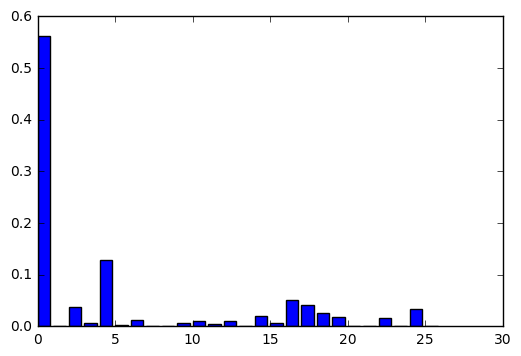

Accuracy of XGB classifier on test set: 0.917860553964
[[2882    0]
 [ 258    1]]
Area Under the precision-recall curve: 0.543000


In [24]:
# You can experiment with many other options here, using the same .fit() and .predict()
# methods; see http://scikit-learn.org
# This example uses the current build of XGBoost, from https://github.com/dmlc/xgboost
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import log_loss
from matplotlib import pyplot

gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(train_X, train_y)
# print(gbm.feature_importances_)
pyplot.bar(range(len(gbm.feature_importances_)), gbm.feature_importances_)
pyplot.show()

predictions = gbm.predict(test_X)
print ('Accuracy of XGB classifier on test set:', gbm.score(test_X,test_y))


print(confusion_matrix(test_df['lead_binary'], predictions))
score = average_precision_score(test_df['lead_binary'].values, predictions)
log_loss = log_loss(test_df['lead_binary'].values, predictions)
print('Area Under the precision-recall curve: {:.6f}'.format(score))



In [22]:
# Logistic Regression
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(train_X, train_y)
y_pred = clf.predict(test_X)
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(test_y, y_pred)
print(confusion_matrix)
score = average_precision_score(test_df['lead_binary'].values, y_pred)
print ('Accuracy of logistic regression classifier on test set:', clf.score(test_X,test_y))
print('area under the precision-recall curve: {:.6f}'.format(score))

# Random Forest
from sklearn.ensemble import RandomForestClassifier
clf1 = RandomForestClassifier(n_estimators=10).fit(train_X, train_y)
# print('Feature importance: ',clf1.feature_importances_)
y_pred1 = clf1.predict(test_X)
from sklearn.metrics import confusion_matrix
confusion_matrix1 = confusion_matrix(test_y, y_pred1)
print(confusion_matrix1)
score1 = average_precision_score(test_df['lead_binary'].values, y_pred)

print ('Accuracy of Random Forest classifier on test set:', clf1.score(test_X,test_y))
print('area under the precision-recall curve: {:.6f}'.format(score1))

# Gradient Boosting Classifier
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
clf2 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
   max_depth=1, random_state=0).fit(train_X, train_y)
# print('Feature importance: ',clf2.feature_importances_)
y_pred2 = clf2.predict(test_X)
from sklearn.metrics import confusion_matrix
confusion_matrix2 = confusion_matrix(test_y, y_pred2)
print(confusion_matrix2)
score2 = average_precision_score(test_df['lead_binary'].values, y_pred)

print ('Accuracy of Gradient Boosting classifier on test set:', clf2.score(test_X,test_y))
print('area under the precision-recall curve: {:.6f}'.format(score2))


[[2882    0]
 [ 259    0]]
Accuracy of logistic regression classifier on test set: 0.917542184018
area under the precision-recall curve: 0.541229
[[2880    2]
 [ 259    0]]
Accuracy of Random Forest classifier on test set: 0.916905444126
area under the precision-recall curve: 0.541229
[[2878    4]
 [ 259    0]]
Accuracy of Gradient Boosting classifier on test set: 0.916268704234
area under the precision-recall curve: 0.541229
